In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Course Project 1
Data Scientists and Analysts spend almost 80% of their time cleaning and analyzing datasets. Currently, we are working with an external research firm who specializes in the application of machine learning to forecasting prices of financial instruments. This firm has developed a proprietary system, that we would like to investigate.

To demonstrate the effectiveness of their forecasting system, the vendor has sent us the attached sample dataset (QF632_Project_1.csv). The dataset includes signal values generated by the proposed system as well as historical prices for a well-known broad market ETF.

[1. Review the quality of the data, list any potential errors, and propose corrected values.](#p1)<br>
[2. Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant](#p2)<br>
[3. Run any exploratory data analysis you think is important and highlight any interesting insights you come across](#p3)<br>
[4. Conclusion](#p4)<br>


## <a id = "p1">Review the quality of the data, list any potential errors, and propose corrected values.</a>
Please list each quality check error and correction applied.<br>
<br>
Summary of checks:
- Checks for missing values
- Checks for duplicated and/or nonsensical entries
- Summary statistics and boxplots for visualizing outliers
- Check outlier in `Adjusted Close` data
- Check outlier in `Close` data
- Check outliers in `Signal` data

In [2]:
df = pd.read_csv('QF632_Project_1.csv')
df.head()

,Date,Signal,Open,High,Low,Close,Adj Close
0,11/19/2015,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601
1,11/20/2015,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323
2,11/23/2015,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453
3,11/24/2015,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837
4,11/25/2015,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159


### Check 1: Missing values
From below summary, no missing value (defined as "blank" entries) in the given data source.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1038 non-null   object 
 1   Signal     1038 non-null   float64
 2   Open       1038 non-null   float64
 3   High       1038 non-null   float64
 4   Low        1038 non-null   float64
 5   Close      1038 non-null   float64
 6   Adj Close  1038 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.9+ KB


### Check 2: Duplicated or nonsensical entries
Just to be sure, we need to ascertain that there is no duplicate in the dates. Here, we would also want to check to make sure that the data consists only market tradable days. From the below checks, we see that while there is no duplicate in dates, we see 4 weekends entries, which should not be there. We leave the weekends entries as is for now.

In [4]:
df['Date'].duplicated().any()

False

In [5]:
df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.day_name()
df['DayOfWeek'].value_counts()

DayOfWeek
Tuesday      212
Wednesday    210
Thursday     209
Friday       209
Monday       194
Saturday       2
Sunday         2
Name: count, dtype: int64

In [6]:
df.loc[df['DayOfWeek'].isin(['Saturday', 'Sunday'])]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
629,5/19/2018,20.448445,162.369995,163.240005,162.360001,162.940002,157.493622,Saturday
630,5/20/2018,19.483907,163.259995,163.330002,161.630005,161.759995,156.352997,Sunday
655,6/23/2018,18.995502,167.240005,167.369995,164.139999,165.080002,159.562042,Saturday
656,6/24/2018,20.274163,165.229996,166.660004,164.850006,166.039993,160.489944,Sunday


Apart from checking for duplicated dates, we want to check if there are any duplicate in market data. Here, if there are consecutive rows of duplicates across 'Open', 'High', 'Low', 'Close', 'Adj Close' columns, the probability of this to be an erroneous entry or deliberate cleaning is much higher.

In [7]:
df.loc[df[['Open', 'High', 'Low', 'Close', 'Adj Close']].duplicated()]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
631,5/21/2018,19.031457,162.369995,163.240005,162.360001,162.940002,157.493622,Monday
632,5/22/2018,19.823488,163.259995,163.330002,161.630005,161.759995,156.352997,Tuesday
657,6/25/2018,21.123096,167.240005,167.369995,164.139999,165.080002,159.562042,Monday
658,6/26/2018,20.198530,165.229996,166.660004,164.850006,166.039993,160.489944,Tuesday


From above, we see that there are four duplicated rows. We need to inspect the preceding rows to make sure that these are not erroneous entries.

In [8]:
df.loc[629:632]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
629,5/19/2018,20.448445,162.369995,163.240005,162.360001,162.940002,157.493622,Saturday
630,5/20/2018,19.483907,163.259995,163.330002,161.630005,161.759995,156.352997,Sunday
631,5/21/2018,19.031457,162.369995,163.240005,162.360001,162.940002,157.493622,Monday
632,5/22/2018,19.823488,163.259995,163.330002,161.630005,161.759995,156.352997,Tuesday


In [9]:
df.loc[655:659]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
655,6/23/2018,18.995502,167.240005,167.369995,164.139999,165.080002,159.562042,Saturday
656,6/24/2018,20.274163,165.229996,166.660004,164.850006,166.039993,160.489944,Sunday
657,6/25/2018,21.123096,167.240005,167.369995,164.139999,165.080002,159.562042,Monday
658,6/26/2018,20.198530,165.229996,166.660004,164.850006,166.039993,160.489944,Tuesday
659,6/27/2018,21.544382,166.210007,166.509995,163.309998,163.380005,157.918869,Wednesday


Here, we have verified that there are indeed duplicated entries, which all occured on the weekends. We shall remove those entries from the data sample.

In [10]:
df_cleaned = df.loc[~df['DayOfWeek'].isin(['Saturday', 'Sunday'])].reset_index(drop=True).copy()

### Check 3: Summary Statistics and boxplot

From visual inspection and summary statistics, the `Open`, `High` and `Low` series appear to be quite clean with no outlier. Extreme outliers exist in `Adjusted Close`, `Close` and `Signal` series. These are the series that we will deep dive into.

In [11]:
df_cleaned.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,16.754451,141.759632,142.604922,140.821335,141.755426,136.255437
std,3.095778,18.456865,18.452561,18.387259,18.481130,21.424646
min,0.000000,94.080002,95.400002,93.639999,94.790001,-152.277847
25%,14.682613,132.007499,132.637501,130.355003,131.654999,124.856003
50%,17.278006,146.720001,147.934998,145.544998,146.674995,142.631638
75%,19.028798,155.287495,156.215000,154.267502,155.237503,151.645275
max,35.434147,172.789993,173.389999,171.949997,196.279999,168.842270


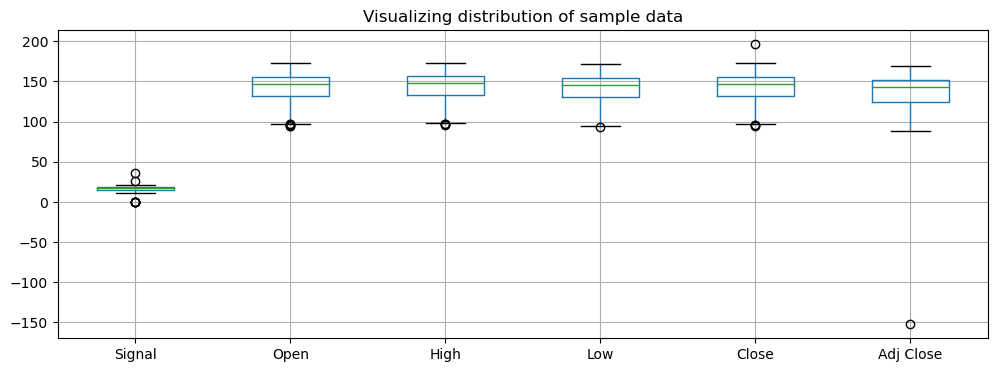

In [12]:
df_cleaned.boxplot(figsize = (12,4))
plt.title('Visualizing distribution of sample data')
plt.show()

### Check 4: outlier in `Adjusted Close` data

From the below, we see that the outlier in `Adj Close` appears to be flipped in sign. It may be likely that this is a data entry error. We can either
1. Linearly interpolate between the preceding and succeeding adjusted close values to replace the outlier
2. Simply flip the sign around

For simplicity and under reasonable assumption, we choose the latter approach.

In [13]:
min_outlier_adjclose = df_cleaned['Adj Close'].idxmin()
df_cleaned.loc[min_outlier_adjclose-5: min_outlier_adjclose+5]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
723,10/3/2018,18.282843,165.179993,166.729996,164.509995,165.970001,161.430481,Wednesday
724,10/4/2018,19.720644,165.440002,165.649994,163.130005,163.639999,159.164215,Thursday
725,10/5/2018,18.354276,163.750000,164.160004,160.660004,162.160004,157.724701,Friday
726,10/8/2018,20.367731,161.770004,162.399994,160.550003,161.820007,157.393982,Monday
727,10/9/2018,26.124873,161.619995,162.740005,160.979996,161.190002,156.781219,Tuesday
728,10/10/2018,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847,Wednesday
729,10/11/2018,18.794839,155.809998,157.320007,153.509995,153.570007,149.369629,Thursday
730,10/12/2018,18.218555,155.559998,155.759995,151.889999,153.600006,149.398819,Friday
731,10/15/2018,18.232469,153.360001,155.289993,152.539993,154.169998,149.953232,Monday
732,10/16/2018,18.738463,155.279999,158.860001,154.039993,158.639999,154.300995,Tuesday


In [14]:
df_cleaned.loc[min_outlier_adjclose, 'Adj Close'] *= -1
df_cleaned.loc[min_outlier_adjclose]

Date         10/10/2018
Signal        19.719477
Open         160.820007
High         160.990005
Low          156.360001
Close        156.559998
Adj Close    152.277847
DayOfWeek     Wednesday
Name: 728, dtype: object

### Check 5: outlier in `Close` data

From the below, we see that the outlier in the `Close` column is `196.279999`. Comparing with the preceding and subsequent rows, this number is around 40 price unit higher than other price points. It is likely to be another data entry error. Here, there are two ways to rectify the error:
1. Take the next day's open price data as a proxy to replace the error in the close price
2. Deduct 40 price unit from the error close price

Unlike in the previous adjustment, the latter approach here may not be the most scientific as it may just be coincidence that the error is about 40 price unit higher. So, the first approach shall be used instead.

In [15]:
max_outlier_close = df_cleaned['Close'].idxmax()
df_cleaned.loc[max_outlier_close - 5:max_outlier_close + 5]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
580,3/12/2018,19.888393,159.250000,159.649994,158.490005,159.199997,153.524109,Monday
581,3/13/2018,19.458666,160.000000,160.300003,158.139999,158.460007,152.810516,Tuesday
582,3/14/2018,19.565586,159.220001,159.389999,157.410004,157.710007,152.087265,Wednesday
583,3/15/2018,18.100298,158.100006,158.139999,156.369995,156.919998,151.325409,Thursday
584,3/16/2018,19.385186,156.979996,158.270004,156.750000,157.800003,152.174042,Friday
585,3/19/2018,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221,Monday
586,3/20/2018,19.177721,156.669998,157.020004,155.770004,156.240005,150.669647,Tuesday
587,3/21/2018,19.019439,156.320007,158.259995,156.199997,157.149994,151.547241,Wednesday
588,3/22/2018,18.899580,155.660004,156.619995,153.309998,153.350006,148.224136,Thursday
589,3/23/2018,17.775879,153.559998,153.940002,150.000000,150.050003,145.034439,Friday


In [16]:
df_cleaned.loc[max_outlier_close, 'Close'] = df_cleaned.loc[max_outlier_close+1, 'Open']
df_cleaned.loc[max_outlier_close]

Date          3/19/2018
Signal        18.660897
Open         157.169998
High         157.210007
Low          154.449997
Close        156.669998
Adj Close    150.708221
DayOfWeek        Monday
Name: 585, dtype: object

### Check 6: outliers in `Signal` data

Here, there are two checks to go through: 
- where `Signal` values equal to 0
- the outliers on high side.

From below, we see that signal values are zero at the end of the data sample. Here, we can consider two approaches
1) Forward fill from last valid signal
2) Remove the rows with zero signal

Given that these are the last 5 entries, it may be more meaningful to remove them altogether rather than filling forward. Filling forward may be unfair as we'd be adding further penalization to the effectiveness of the signal in forecasting the price. The last few entries can be forgone given that we have sufficient data points.

In [17]:
df_cleaned.loc[df_cleaned['Signal']==0]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
1028,12/27/2019,0.0,167.119995,167.119995,165.429993,165.860001,164.039063,Friday
1029,12/30/2019,0.0,165.979996,166.210007,164.570007,165.440002,163.623688,Monday
1030,12/31/2019,0.0,165.080002,166.350006,164.710007,165.669998,163.851135,Tuesday
1031,1/2/2020,0.0,166.740005,166.750000,164.229996,165.779999,163.959946,Thursday
1032,1/3/2020,0.0,163.740005,165.410004,163.699997,165.130005,163.317093,Friday
1033,1/6/2020,0.0,163.850006,165.539993,163.539993,165.350006,163.534668,Monday


In [18]:
df_cleaned = df_cleaned.loc[df_cleaned['Signal']!=0].reset_index(drop = True)

For the second check on the signal outlier, we identified two data points that are much higher than the rest, namely,
- index 500, `Signal` = 35.434147
- index 727, `Signal` = 26.124873

Further inspection shows that the biggest outlier stood out from its neighbouring data points by about two times, while no visible pattern can be seen for the second outlier. Here, we shall divide the biggest outlier by 2 so that it reverts to a level comparable to its neighbouring data points. We shall keep the second outlier unchanged.

In [19]:
p98_signal = df_cleaned['Signal'].quantile(0.98)
df_cleaned.loc[df_cleaned['Signal']> p98_signal].sort_values(by = 'Signal', ascending=False)

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
500,11/13/2017,35.434147,145.929993,146.820007,145.500000,146.610001,140.849274,Monday
727,10/9/2018,26.124873,161.619995,162.740005,160.979996,161.190002,156.781219,Tuesday
705,9/7/2018,21.712125,170.210007,171.449997,169.660004,170.539993,165.436493,Friday
1018,12/12/2019,21.667517,162.750000,165.100006,162.250000,163.960007,161.567200,Thursday
696,8/24/2018,21.655552,171.149994,171.779999,171.020004,171.589996,166.455048,Friday
691,8/17/2018,21.604009,167.470001,168.470001,166.929993,168.350006,163.311996,Friday
657,6/29/2018,21.581519,164.309998,165.050003,163.610001,163.770004,158.295853,Friday
713,9/19/2018,21.574588,170.279999,171.070007,169.070007,169.649994,164.573120,Wednesday
685,8/9/2018,21.557183,167.649994,168.710007,167.550003,168.000000,162.972519,Thursday
655,6/27/2018,21.544382,166.210007,166.509995,163.309998,163.380005,157.918869,Wednesday


In [20]:
max_outlier_signal = df_cleaned['Signal'].idxmax()
df_cleaned.loc[max_outlier_signal-5:max_outlier_signal+5]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
495,11/6/2017,17.079084,148.750000,149.380005,148.389999,148.779999,142.934006,Monday
496,11/7/2017,16.897302,148.800003,148.850006,146.539993,147.000000,141.223938,Tuesday
497,11/8/2017,16.901913,146.660004,147.449997,145.839996,147.199997,141.416107,Wednesday
498,11/9/2017,17.361475,146.270004,147.389999,145.279999,146.679993,140.916534,Thursday
499,11/10/2017,17.628384,146.710007,147.100006,146.350006,146.570007,140.810852,Friday
500,11/13/2017,35.434147,145.929993,146.820007,145.500000,146.610001,140.849274,Monday
501,11/14/2017,17.456319,146.059998,146.490005,145.589996,146.210007,140.465012,Tuesday
502,11/15/2017,17.928089,145.350006,146.210007,144.500000,145.630005,139.907806,Wednesday
503,11/16/2017,18.115129,146.210007,148.399994,146.190002,147.770004,141.963730,Thursday
504,11/17/2017,18.091144,147.250000,149.029999,147.169998,148.449997,142.616989,Friday


In [21]:
df_cleaned.loc[max_outlier_signal, 'Signal'] /= 2
df_cleaned.loc[max_outlier_signal]

Date         11/13/2017
Signal        17.717074
Open         145.929993
High         146.820007
Low               145.5
Close        146.610001
Adj Close    140.849274
DayOfWeek        Monday
Name: 500, dtype: object

In [22]:
second_outlier_signal = df_cleaned['Signal'].sort_values(ascending=False).index[1]
df_cleaned.loc[second_outlier_signal-5:second_outlier_signal+5]

,Date,Signal,Open,High,Low,Close,Adj Close,DayOfWeek
700,8/30/2018,20.870663,172.169998,173.229996,171.820007,172.360001,167.202026,Thursday
701,8/31/2018,20.705795,171.960007,173.389999,171.949997,172.020004,168.842270,Friday
702,9/4/2018,20.457543,172.789993,173.119995,171.119995,172.250000,167.095306,Tuesday
703,9/5/2018,21.455656,172.179993,172.229996,170.360001,171.789993,166.649048,Wednesday
704,9/6/2018,21.346674,172.169998,172.479996,170.419998,170.630005,165.523804,Thursday
705,9/7/2018,21.712125,170.210007,171.449997,169.660004,170.539993,165.436493,Friday
706,9/10/2018,20.217368,171.250000,171.679993,170.389999,170.750000,165.640182,Monday
707,9/11/2018,21.328676,170.600006,171.600006,170.000000,171.029999,165.911819,Tuesday
708,9/12/2018,21.526058,170.789993,171.089996,169.330002,170.619995,165.514099,Wednesday
709,9/13/2018,19.836077,171.279999,171.539993,170.259995,170.660004,165.552902,Thursday


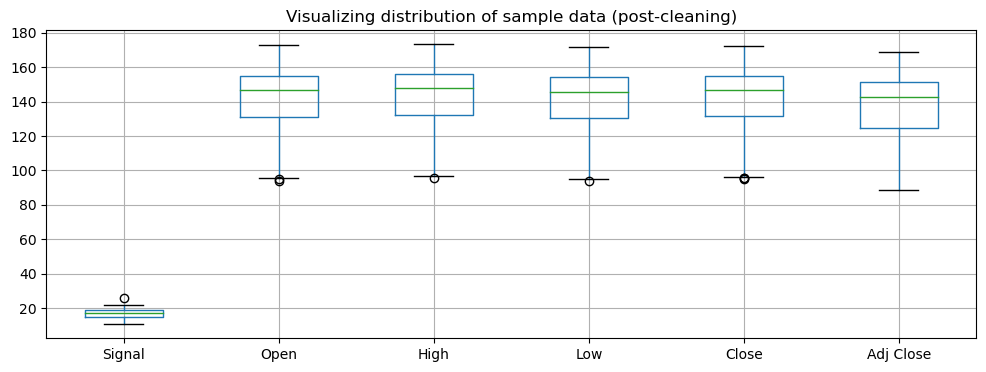

In [23]:
df_cleaned.boxplot(figsize = (12,4))
plt.title('Visualizing distribution of sample data (post-cleaning)')
plt.show()

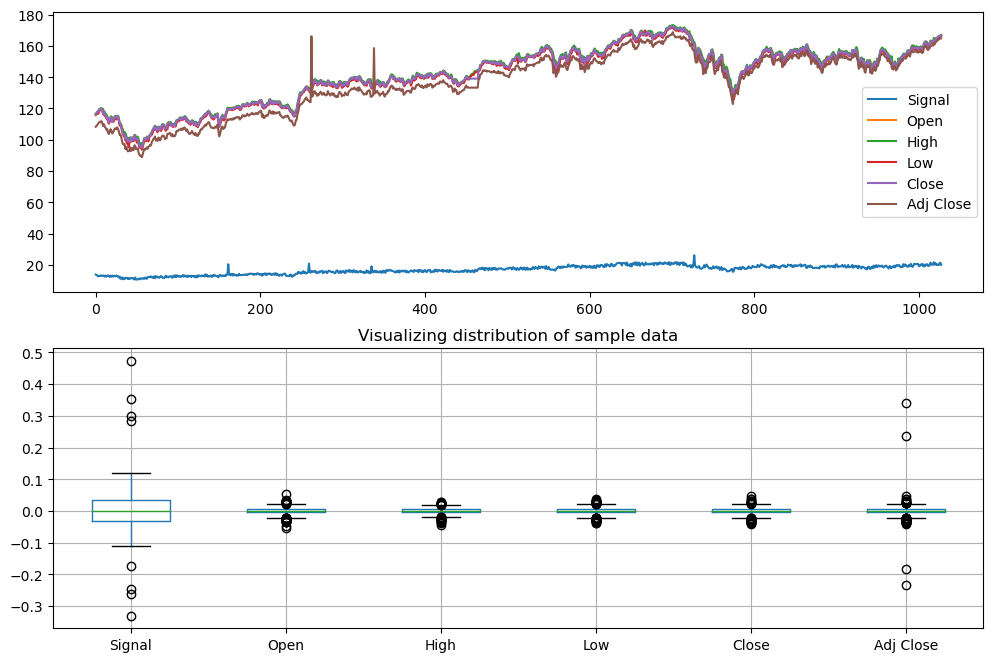

In [24]:
fig, axs = plt.subplots(2,1,figsize = (12,8))
df_cleaned[['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']].plot(ax=axs[0])
df_cleaned[['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']].pct_change().boxplot(ax=axs[1])
plt.title('Visualizing distribution of sample data')
plt.show()

In [25]:
df_return = df_cleaned[['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']].pct_change().copy()

# Trimming the extremes
lower_limit = df_return[['Adj Close']].quantile(0.01)
upper_limit = df_return[['Adj Close']].quantile(0.99)

trimmed_idx = df_return.loc[df_return['Adj Close'].between(lower_limit.values[0], upper_limit.values[0])].index
df_trimmed  = df_cleaned.loc[trimmed_idx , :].copy()

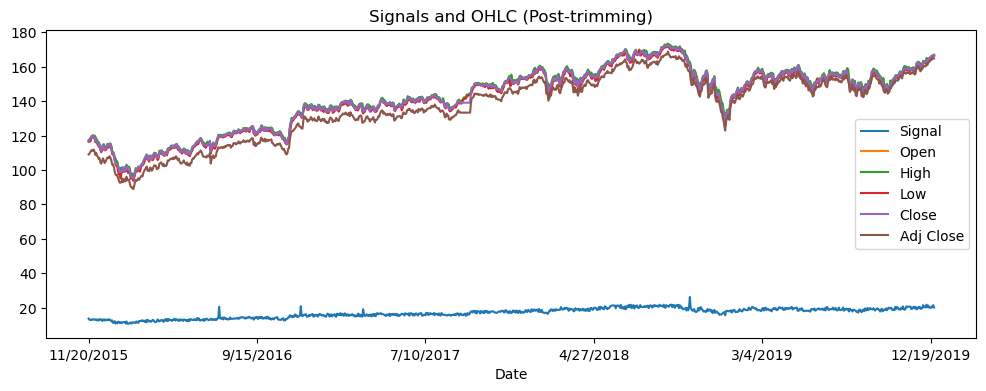

In [26]:
df_trimmed.set_index(['Date'], drop=True, inplace=True)
df_trimmed.drop(columns = 'DayOfWeek', inplace=True)
df_trimmed.plot(title = 'Signals and OHLC (Post-trimming)', figsize=(12,4))
plt.show()

## <a id = "p2">Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.</a>

We shall evaluate the effectiveness of the signal in forecasting the ETF prices (specifically the Adjusted Close), based on three methods:
- Compare normalized value of signal vs normalized value of the adjusted close prices
- Compare rolling mean value of the normalized signal vs normalized value of the adjusted close prices
- Compare the predicted ETF prices derived from linear regression given signal vs the adjusted close prices

The metrics used are MSE, RMSE and R-squared score.

In addition, we also evaluated the "win rate" of the signal, based on the direction of prediction vs actualized adjusted close prices.

In [27]:
def obtain_metrics(actual, signal, label, verbose = False):
    mse = mean_squared_error(actual, signal)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, signal)

    if verbose:
        print(f'Method: {label}\n MSE: {mse:.4f}\n RMSE: {rmse:.4f}\n R2:{r2:.4f}')

    return {
        'Method': label,
        'MSE' : mse,
        'RMSE' : rmse,
        'R2' : r2
    }

evaluation = []

From the plot above, we see that the signal is on the different magnitude compared to the adjusted close price. In order to compare the signal vs the actual adjusted close price, we'd need to scale the data to comparable size.<br>

Instead of scaling using standardization (which requires the mean and standard deviation to be known, thus data leakage), we shall normalize the time series, basing it to the first observation instead.<br>

The below plot shows the comparison between normalized signal vs normalized ETF adjusted close prices. Here, we observed that the signal is extremely noisy. Despite the noise, it achieved a decent R-squared score of 0.87.

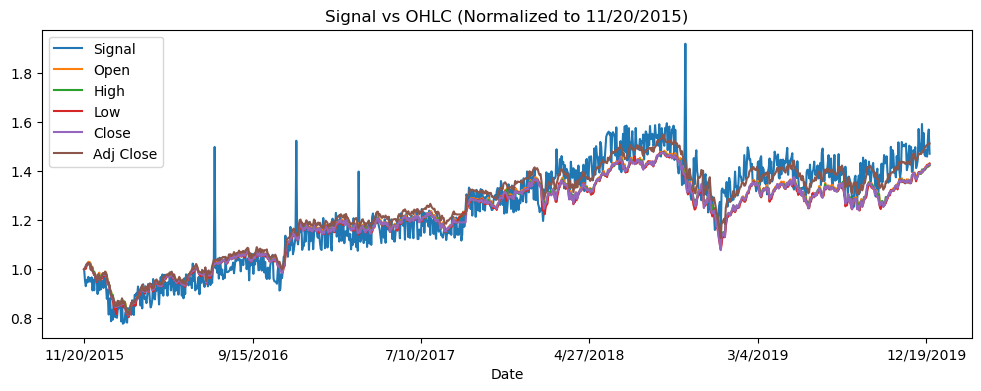

Method: Normalized Signal vs Normalized Adj Close
 MSE: 0.0040
 RMSE: 0.0634
 R2:0.8724


In [28]:
# Comparing normalized signal vs normalized etf prices
df_normalized = df_trimmed[['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']].copy()
df_normalized /= df_normalized.iloc[0]
df_normalized.plot(title = 'Signal vs OHLC (Normalized to 11/20/2015)', figsize=(12,4))
plt.show()

evaluation.append(
    obtain_metrics(df_normalized['Adj Close'], df_normalized['Signal'], 'Normalized Signal vs Normalized Adj Close', verbose = True)
)

One way to reduce the noise is to smoothen the signal. This can be done by using a rolling window mean, with a minimum period of one. While this may be viewed as "over-engineering" the signal, we shall try this method nonetheless, just to see how well the smoothened normalized signal work.<br>

From the analysis below, we see that the smoothened signal fits the normalized adj close price much better, with a better MSE and R-squared of 94%.

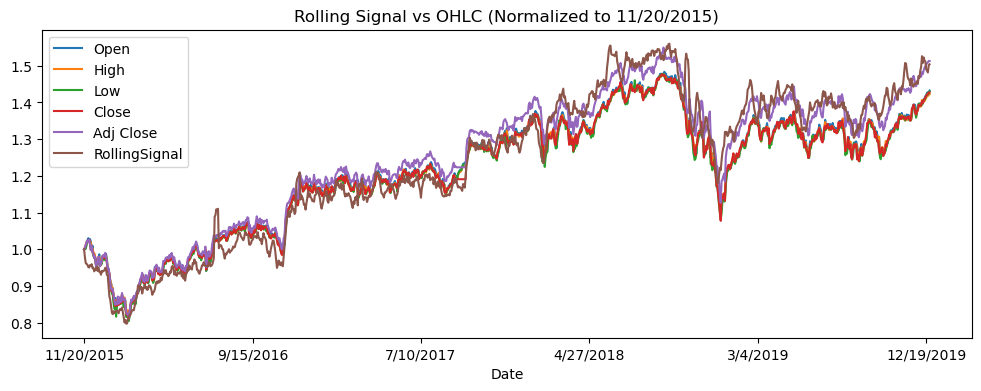

Method: Normalized Rolling Signal vs Normalized Adj Close
 MSE: 0.0019
 RMSE: 0.0431
 R2:0.9410


In [29]:
df_normalized['RollingSignal'] = df_normalized['Signal'].rolling(window = 5, min_periods=1).mean()

df_normalized[['Open', 'High', 'Low', 'Close', 'Adj Close', 'RollingSignal']].plot(title = 'Rolling Signal vs OHLC (Normalized to 11/20/2015)', figsize=(12,4))
plt.show()

evaluation.append(
    obtain_metrics(df_normalized['Adj Close'], df_normalized['RollingSignal'], 'Normalized Rolling Signal vs Normalized Adj Close', verbose = True)
)

Basing the signals and the ETF adjusted close price to the first observation may be controversial, as it could be very sensitive to the first observation itself. Another way of analyzing the general fit of the signal to the actual ETF adjusted close price is to run a linear regression. The following analysis does just that.<br>

After running the regression and comparison the in-sample predicted price vs actual price, we see that the predicted price based on the signal is still very noisy. 

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 1.071e+04
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:14:45   Log-Likelihood:                -3168.5
No. Observations:                1005   AIC:                             6341.
Df Residuals:                    1003   BIC:                             6351.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8156      1.103     21.583      0.0

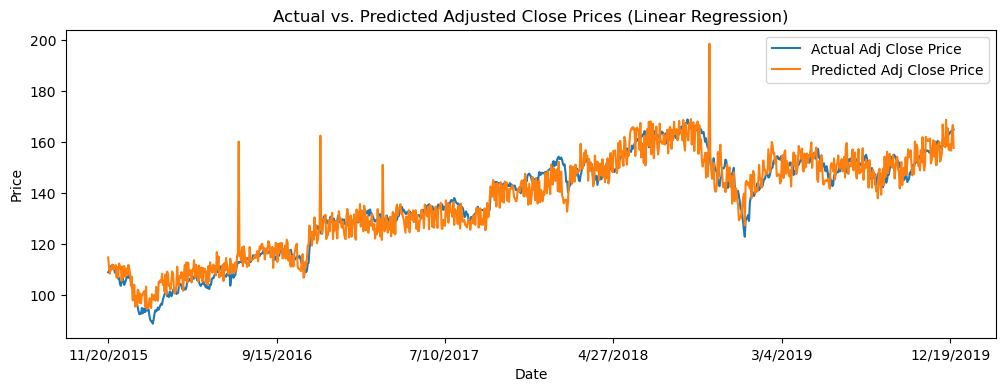

Method: Linear Regression
 MSE: 32.0603
 RMSE: 5.6622
 R2:0.9144


In [30]:
# Linear Regression of signal on adjusted close
X = df_trimmed['Signal']
y = df_trimmed['Adj Close']

# Add a constant to the independent variable (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get the model summary
model_summary = model.summary()

# Print the model summary
print(model_summary)

# Predict the values
df_trimmed['Predicted'] = model.predict(X)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 4))
df_trimmed['Adj Close'].plot(label = 'Actual Adj Close Price')
df_trimmed['Predicted'].plot(label = 'Predicted Adj Close Price')
plt.title('Actual vs. Predicted Adjusted Close Prices (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate Mean Squared Error
evaluation.append(
    obtain_metrics(df_trimmed['Adj Close'], df_trimmed['Predicted'], 'Linear Regression', verbose = True)
)


Overall, comparing the three analysis, the effectiveness of the signal to forecast the ETF price may seem decent when looking at the MSE and the R-squared. All three methods returned high R2 scores of above 85%. However, a better way of deciding if the signal works well to forecast the price is through the win-ratio.<br>

As the direction of the price movement is what traders act upon, we want to see how well the signal forecast the direction of the closing price. Below analysis shows that the signal works poorly, with a win-ratio of 46%, which is worse than a random guess.

In [31]:
pd.DataFrame(evaluation)

,Method,MSE,RMSE,R2
0,Normalized Signal vs Normalized Adj Close,0.004022,0.063422,0.872395
1,Normalized Rolling Signal vs Normalized Adj Close,0.001860,0.043131,0.940984
2,Linear Regression,32.060300,5.662182,0.914366


In [32]:
df_trimmed['Adj Close Diff'] = np.sign(df_trimmed['Adj Close'].diff())
df_trimmed['Signal Diff'] = np.sign(df_trimmed['Signal'].diff())

df_trimmed['Right Way Pred'] = df_trimmed['Signal Diff'] == df_trimmed['Adj Close Diff']
print(f'Win rate = {df_trimmed["Right Way Pred"].mean():.2%}')

Win rate = 46.17%


In [40]:
df_normalized['RollingSignal Diff'] = np.sign(df_normalized['RollingSignal'].diff())
df_normalized['Adj Close Diff'] = np.sign(df_normalized['Adj Close'].diff())

df_normalized['Right Way Pred'] = df_normalized['RollingSignal Diff'] == df_normalized['Adj Close Diff']
print(f'Win rate = {df_normalized["Right Way Pred"].mean():.2%}')

Win rate = 50.55%


## <a id = "p3">Run any exploratory data analysis you think is important and highlight any interesting insights you come across</a>

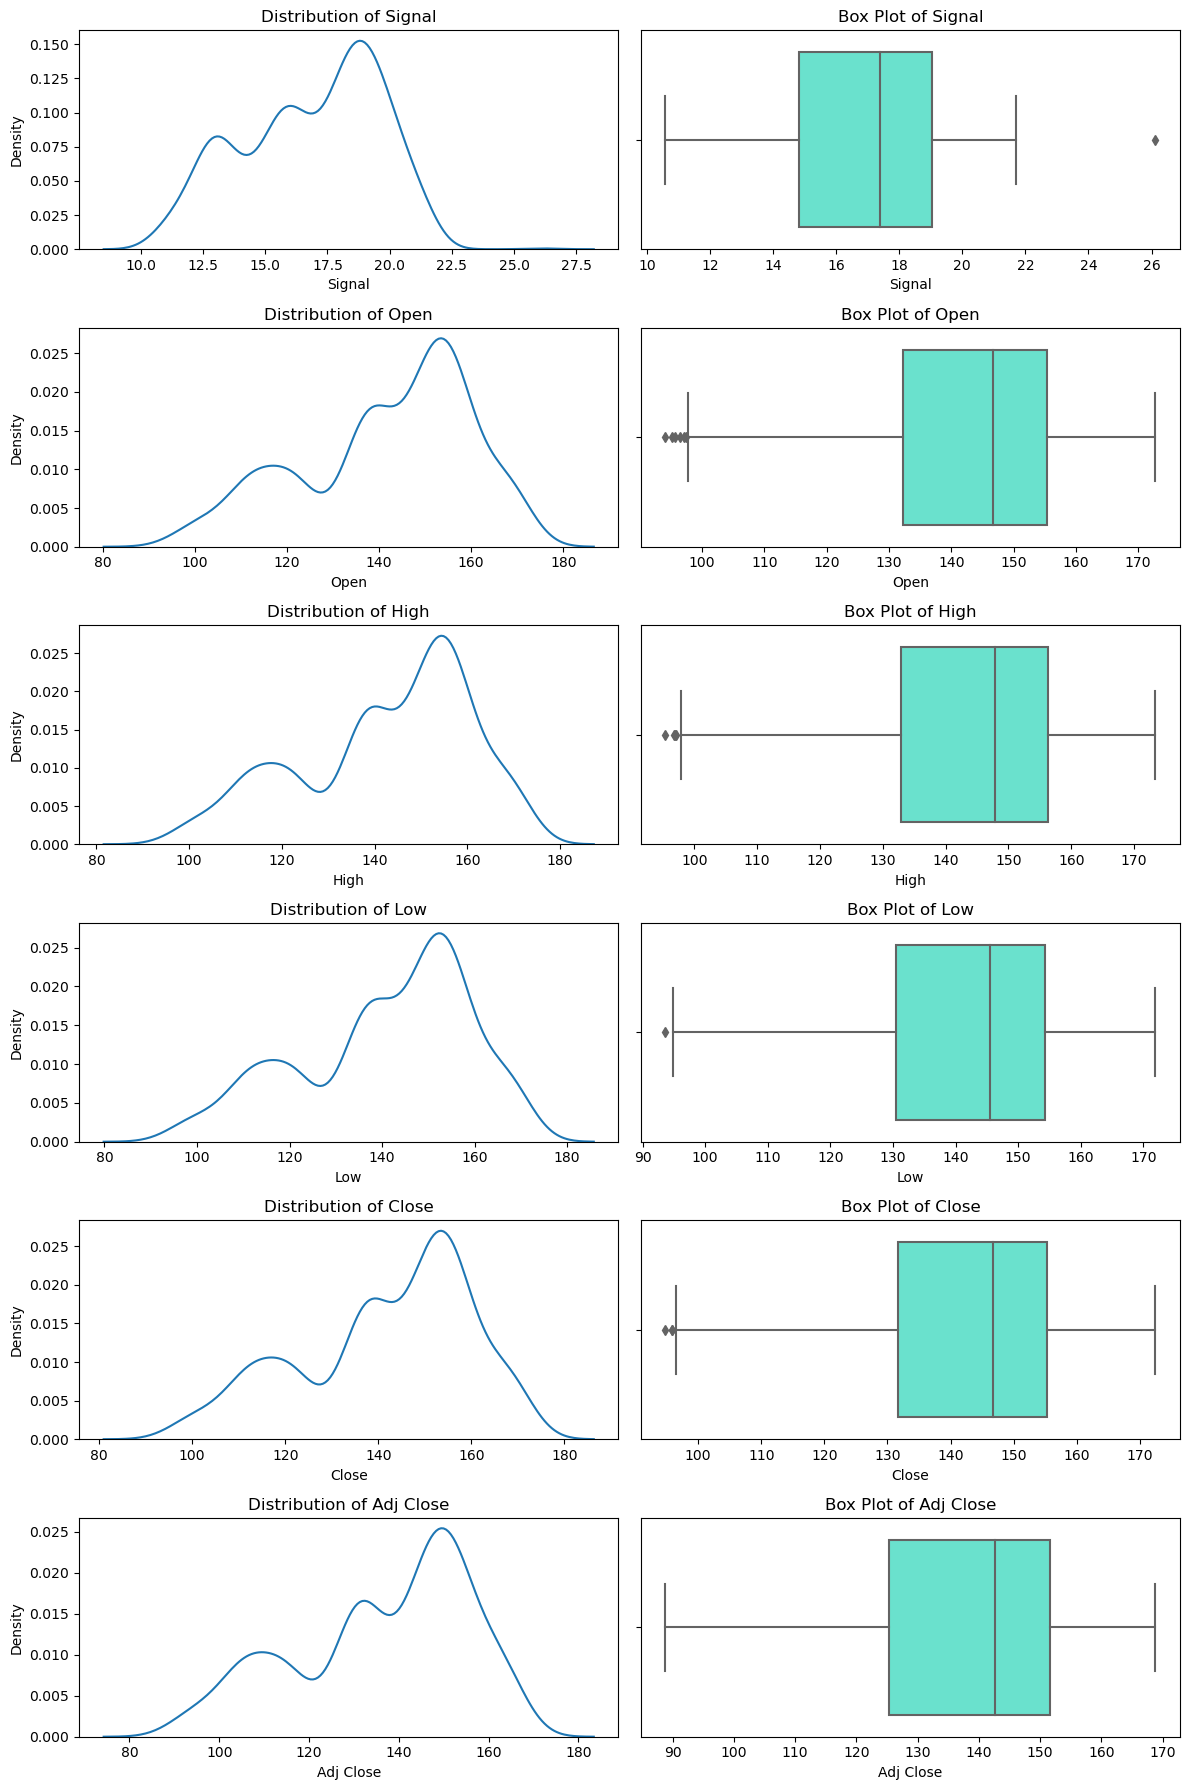

In [33]:
fig, axs = plt.subplots(6, 2, figsize=(12, 18))

for idx, column in enumerate(['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']):
    # Histogram
    sns.kdeplot(data=df_trimmed, x=column, ax=axs[idx, 0])
    axs[idx,0].set_title(f'Distribution of {column}')
    # Box Plot
    sns.boxplot(x=df_trimmed[column], color='#56f5da', ax=axs[idx, 1])
    axs[idx,1].set_title(f'Box Plot of {column}')

plt.tight_layout()

plt.show()

In [36]:
df_return.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000
mean,0.001774,0.000402,0.000386,0.000402,0.000406,0.000582
std,0.053513,0.010182,0.008606,0.009838,0.010342,0.018912
min,-0.330036,-0.053984,-0.045611,-0.036805,-0.042575,-0.232498
25%,-0.031284,-0.004889,-0.004237,-0.004616,-0.004784,-0.004851
50%,0.000730,0.000891,0.000551,0.000763,0.000887,0.000925
75%,0.033897,0.006164,0.005463,0.006288,0.006440,0.006508
max,0.473045,0.052337,0.028256,0.038712,0.048062,0.339658


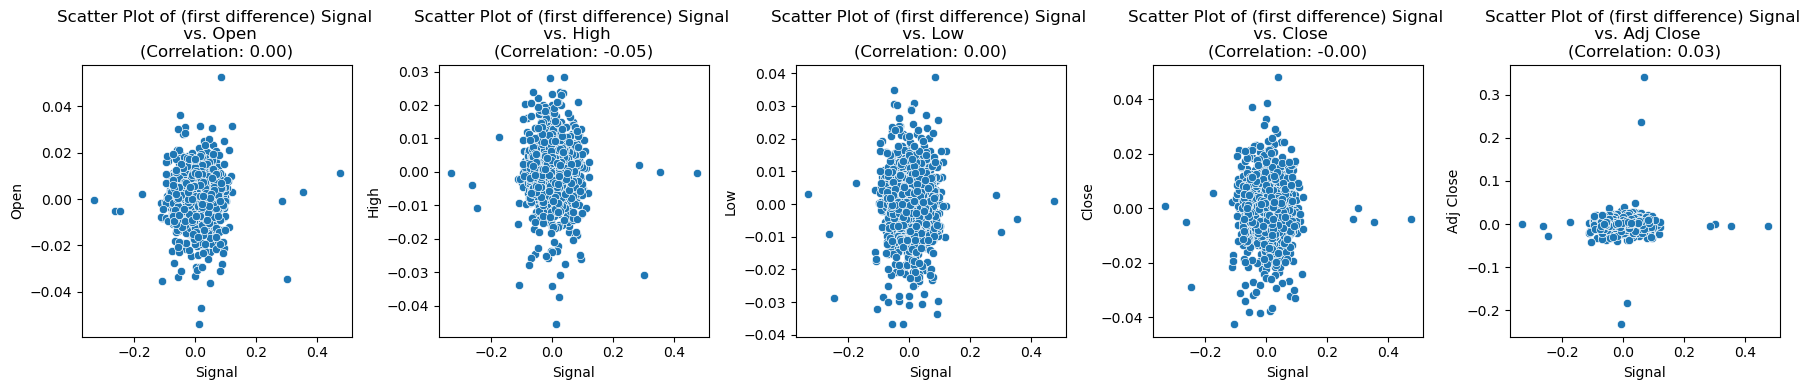

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4))

for idx, column in enumerate(['Open', 'High', 'Low', 'Close', 'Adj Close']):
    # Calculate correlation
    corr_coef = df_return[['Signal', column]].corr().iloc[0,1]
    # Scatter Plot
    sns.scatterplot(x='Signal', y=column, data=df_return, ax = axs[idx])
    axs[idx].set_title(f'Scatter Plot of (first difference) Signal \n vs. {column}\n(Correlation: {corr_coef:.2f})')

plt.tight_layout()

plt.show()

## <a id = "p4">Conclusion</a>

Overall, the signal performed poorly to forecast the price of the ETF. 
- The signal generated is too noisy; the first difference of the signal has much higher standard deviation than the actual price returns, as seen from the additional exploratory data analysis
- Despite the relative strong R-squared and MSE scores, the win rate of the signal to forecast ETF adjusted close price fell short at 46%
- Scatter plot above, comparing the signal "return" vs the ETF returns, showed that the signal return has zero correlation with the ETF returns

However, from a naive rolling mean method, we see that after smoothening the signal, there is some improvement to the R-squared score and the win-ratio.
- A robust technique to de-noise the signal to be used for ETF forecast could help with improving the forecastability of the signal

